In [6]:
#batch norm removed, dropout probability to 0.5
#dropout added to fc  not good

#remove vectors after 4096 to be similar to paper, sigmoid is added to each out put, still keep the contrast loss
#modify the net, sigmoid on out put of the outpu1-output2, then get to the 1*1 then,cross entropy

#decided to get the dropout to 0.2, 0.5 not working, kept batch norm, using sigmoid as original paper and droppping the dimensions to 
# 4096 and the 1 with sigmoid and using absolute distance not worked (with BCE losss)

#using contrast loss but kept all 4096 for now as inout to loss,  


#had to go back keep to 4096 to 5 (need definitely batch norm), question put dropout in fc? margin impact now with 2.0

#margin 5 or 1 did not work out just running it longer 200 epochs

#added dropout (0.2) for fc not bad, does it need more than 200 or higher dropout probability?

# test loader option with a flag is added to get if needed same probability of classes as second image or accuracy calculation

#model is also saved

#for omniglot images are png, had trouble opening with PIL (with imshow was all black), used cv2 and array, only tranformed
#using tensor since other trasnforms needed PIL!!!! annoying. per language brough one alphabet and ~20 instances per alphabet

#after reloading the model had to be tested as none cude since weights not saved with cuda!


import numpy as np
import torch
from torch import nn
import torch.functional as F
import torchvision
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms,utils, models
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import OrderedDict
from PIL import Image
import cv2


In [7]:
test=[]
test2=[]
for i in range(1000):
    test.append(np.random.randint(2))
    test2.append(np.random.randint(0,1))


In [8]:
np.mean(test)

0.48799999999999999

In [9]:
np.mean(test2)

0.0

In [10]:

class att_dataset(Dataset):
    
    def __init__(self,main_dir,data_transorm,flag_train):
        
        #self.train_dir=main_dir+'train/'
        #self.test_dir=main_dir+'test/'
        self.main_dir_=main_dir
        self.data_transform=data_transorm
        self.flag_train=flag_train

        #self.trainset = datasets.ImageFolder(self.train_dir, transform=data_transform)
        self.mainset = datasets.ImageFolder(self.main_dir_)
        self.len=len(list(self.mainset.imgs))   #self.trainset.imgs gives tuples
        #print(self.len)
        self.classes=list(self.mainset.classes)
        self.len_classes=len(self.classes)
        #print(len(self.classes))
        
        #testset = datasets.ImageFolder(self.test_dir, transform=data_transform)

                      
    def __getitem__(self,index):
        
        indx1 = np.random.choice(len(self.mainset.imgs))
        img1=self.mainset.imgs[indx1]  #tuple first image
        #print(img1)
        
        
        #make 50% 
        if(self.flag_train):
            

            random_gen=np.random.randint(2)

            while True:   

                index2 = np.random.choice(len(self.mainset.imgs))
                img2=self.mainset.imgs[index2]

                if ((img1[1]==img2[1]) and (random_gen==1)):   #label checking
                    indx2=index2
                    img2=img2

                    break

                if ((img1[1]!=img2[1]) and (random_gen==0)):   #label checking
                    indx2=index2
                    img2=img2

                    break 
                    
        else:
            
            random_gen_class=np.random.choice(len(self.mainset.imgs))
            img2=self.mainset.imgs[random_gen_class]   #want to make sure if pick 1st image for testing 2nd image coming from random classes
            if((img1[1]!=img2[1])): 
                random_gen=0
            else: 
                random_gen=1
            
            
                
        #img0_ = Image.open(img1[0])
        #img1_ = Image.open(img2[0])
        
        img0_=cv2.imread(img1[0],0)
        img1_=cv2.imread(img2[0],0)
        
        #img0_.load()
        img0_ = np.asarray( img0_, dtype="int32" )
        #print(img0_.shape)
        img0_=np.reshape(img0_,(img0_.shape[0],img0_.shape[1],1))
        #print(img0_.shape)

        #img1_.load()
        img1_ = np.asarray( img1_, dtype="int32" )
        img1_=np.reshape(img1_,(img1_.shape[0],img1_.shape[1],1))
        
        img0_ = self.data_transform(img0_)
        img1_ = self.data_transform(img1_)
        

                
                
        return img0_,img1_,torch.from_numpy(np.array([random_gen],dtype=np.float32))
                  
    
    def __len__(self):
                       
        return self.len
    
    

                                                
                                                
# TODO: Using the image datasets and the trainforms, define the dataloaders


#test_loader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True)     

In [11]:
for i in range(10):
    print(np.random.choice(10))

2
5
6
3
5
7
7
0
9
4


In [19]:
main_dir='omniglot/train/'
#train_dir=main_dir+'train/'
#test_dir=main_dir+'test/'
batch_size=32

#data_transform_train = transforms.Compose([transforms.Resize(112),transforms.RandomRotation([-30,30]),
#         transforms.CenterCrop(105),transforms.RandomHorizontalFlip(),
#         transforms.ToTensor()]) #,transforms.Normalize((0.5,), (0.5,))

data_transform_train=transforms.Compose([transforms.ToTensor()]) 
data_transform_test=transforms.Compose([transforms.ToTensor()]) 
dataset_att=att_dataset(main_dir='omniglot/train/',data_transorm=data_transform_train,flag_train=True)
train_loader = torch.utils.data.DataLoader(dataset_att, batch_size=batch_size,shuffle=True)

#data_transform_test = transforms.Compose([transforms.Resize(112),
#         transforms.CenterCrop(105),
#         transforms.ToTensor()]) #,transforms.Normalize((0.5,), (0.5,))
dataset_att2=att_dataset(main_dir='omniglot/train/',data_transorm=data_transform_test,flag_train=False)
test_loader = torch.utils.data.DataLoader(dataset_att2, batch_size=batch_size,shuffle=True)

In [34]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

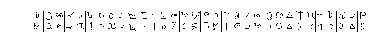

[[ 0.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]


In [190]:
example_batch = next(iter(train_loader))
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated,nrow=batch_size))
print(example_batch[2].numpy())
#plt.imshow(example_batch[0])



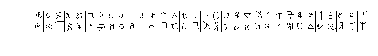

[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]


In [191]:
example_batch = next(iter(test_loader))
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated,nrow=batch_size))
print(example_batch[2].numpy())

In [192]:
# image,label=next(iter(train_loader))
# print(image.size())
# print(label.size())
# for i in range(5):
    
#     plt.imshow(image[i][0])
#     plt.show

In [12]:
class simese_network(nn.Module):
    def __init__(self):
        super(simese_network,self).__init__()
        
        self.conv1=nn.Conv2d(1,64,kernel_size=10)   # (105-10-0)/1 +1=96     96*96*64 
        self.relu1=nn.ReLU()                        #                        96*96*64
        self.maxpool1=nn.MaxPool2d(kernel_size=2)   #                        48*48 *64
        self.batchnorm1=nn.BatchNorm2d(64)
        self.dropout1=nn.Dropout2d(p=0.2)
        
        self.conv2=nn.Conv2d(64,128,kernel_size=7)  #  (48-7-0)/1+1= 42     42*42*128
        self.relu2=nn.ReLU()                        #                       42*42*128
        self.maxpool2=nn.MaxPool2d(kernel_size=2)   #                       21*21*128
        self.batchnorm2=nn.BatchNorm2d(128)
        self.dropout2=nn.Dropout2d(p=0.2)
        
        self.conv3=nn.Conv2d(128,128,kernel_size=4) # (21-4-0)/1+1= 18     18*18*128
        self.relu3=nn.ReLU()                        #                      18*18*128
        self.maxpool3=nn.MaxPool2d(kernel_size=2)   #                      9*9*128
        self.batchnorm3=nn.BatchNorm2d(128)
        self.dropout3=nn.Dropout2d(p=0.2)
        
        self.conv4=nn.Conv2d(128,256,kernel_size=4) # (9-4-0)/1+1=6       6*6*256 
        self.relu4=nn.ReLU() 
        self.batchnorm4=nn.BatchNorm2d(256)
        self.dropout4=nn.Dropout2d(p=0.2)
        
        self.linear1=nn.Linear(9216,4096)  ##self.linear2=nn.Linear(4096,1)    
        self.relu5=nn.ReLU()
        self.dropout5=nn.Dropout(p=0.2)
        
        self.linear2=nn.Linear(4096,512)
        self.relu6=nn.ReLU()
        self.dropout6=nn.Dropout(p=0.2)
        
        self.linear3=nn.Linear(512,10)
        self.relu7=nn.ReLU()  
        self.dropout7=nn.Dropout(p=0.2)
        
        self.linear4=nn.Linear(10,5)       
        
        
        

    def forward_main(self,x):
        
        self.in_channel_batch=x.size(0)
        
        x=self.dropout1(self.batchnorm1(self.maxpool1(self.relu1(self.conv1(x)))))
              
        x=self.dropout2(self.batchnorm2(self.maxpool2(self.relu2(self.conv2(x)))))
        
        x=self.dropout3(self.batchnorm3(self.maxpool3(self.relu3(self.conv3(x)))))
        
        x=self.dropout4(self.batchnorm4(self.relu4(self.conv4(x))))
        
        x=x.view(self.in_channel_batch,-1)  #batch batch size* -1,  
        
        
        #x=self.linear1(x)
        
        x=self.dropout5(self.relu5(self.linear1(x)))
        x=self.dropout6(self.relu6(self.linear2(x)))       
        x=self.dropout7(self.relu7(self.linear3(x)))
        
        x=self.linear4(x)
        
        #output=F.sigmoid(x)
        
        output=x
        
        return output
    
    
    def forward(self,x1,x2):
        
        output1=self.forward_main(x1)
        output2=self.forward_main(x2)
        
        #xx=((F.pairwise_distance(output1,output2,p=1,keepdim=False)))  #it seemd to be more stable to use logit loss that does sigmoid inside it, than BCE loss with sigmoid done in forward
        #xx=xx.view(self.in_channel_batch,-1)
        #xx=torch.FloatTensor.abs(output1-output2)
        #xx=self.linear2(xx)
        #output_=F.sigmoid(xx)
        
        return output1,output2
        
    
    
    

In [13]:

class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive


In [28]:
model=simese_network()

In [29]:
epochs=500
criterion=ContrastiveLoss()  
#criterion=torch.nn.BCEWithLogitsLoss(size_average=True)
#criterion=torch.nn.BCELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.0005)  #had to change from SGD to Adam but later noy much difference

lr_scheduler_=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
#lr_scheduler_=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=epochs)

In [197]:
within_run_loss=[]
step_=[]
avg_loss_=[]
def train_function(train_loader):
    loss_running=0
    count=0
    count_batch=0
    sum_acc=0
    
    model.to(device)

    for epoch in range(epochs):

        for step,(img1,img2,labels) in enumerate(train_loader):
            
            
            
            img1=img1.to(device)
            img2=img2.to(device)
            labels=labels.to(device)
            #print(labels)
            optimizer.zero_grad()
            #input.resize_(input.size()[0], 784)   take to forward
            output1,output2=model(img1,img2)   #this is 64 (bacth_size)*10
            
            #if(count==0): print(y_pred.size(),labels.size())
            loss=criterion(output1,output2,labels)    #criterion(y_pred,label), crossentropy criterion need long (output of forward) and normal tensor (target)
            loss_running=loss_running+loss.item()
            
            loss.backward()
            optimizer.step()
            count=count+1
            #y_pred_round=torch.round(y_pred)
            count_batch=count_batch+(labels.size()[0])
            #_,y_pred_=torch.max(y_pred,dim=1)    #argmax is the second value returned by torch.max()  ,this collapse dimension to batch size with argmax of probabililty/value (second) item, first one is the value itself 

            #acc=(labels==y_pred_).sum().item()    #/label.size()[0]
            #sum_acc=sum_acc+acc
            #print(count)
            if(step%500==0): 
                
                print('epoch',epoch+1,'/',epochs,'avg train running_loss:',(loss_running/count_batch),'within run loss',loss.item())  #,'Accuracy',(sum_acc*100/count_batch))
                within_run_loss.append(loss.item())
                #step_=[]
                avg_loss_.append(loss_running/count_batch)
                print('-----')
                #test_function(test_loader)
                #print('---------------------')
                #model.train()
            
        check_loss=(loss_running/count_batch)
        lr_scheduler_.step(check_loss)



In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [198]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
train_function(train_loader)

cuda
epoch 1 / 500 avg train running_loss: 0.05843639373779297 within run loss 1.869964599609375
-----
epoch 2 / 500 avg train running_loss: 0.03811163106296636 within run loss 1.0841840505599976
-----
epoch 3 / 500 avg train running_loss: 0.03823423414648353 within run loss 1.202191948890686
-----
epoch 4 / 500 avg train running_loss: 0.037914404377146056 within run loss 1.02351713180542
-----
epoch 5 / 500 avg train running_loss: 0.03782204729749968 within run loss 1.177718997001648
-----
epoch 6 / 500 avg train running_loss: 0.03735111795346152 within run loss 0.9636133909225464
-----
epoch 7 / 500 avg train running_loss: 0.037277667057015296 within run loss 1.1824828386306763
-----
epoch 8 / 500 avg train running_loss: 0.03700242290143029 within run loss 1.1829830408096313
-----
epoch 9 / 500 avg train running_loss: 0.036883500842562575 within run loss 1.1409916877746582
-----
epoch 10 / 500 avg train running_loss: 0.03686987516499057 within run loss 1.2553859949111938
-----
epoch 

epoch 83 / 500 avg train running_loss: 0.0350461199826376 within run loss 1.1702187061309814
-----
epoch 84 / 500 avg train running_loss: 0.03503737717670735 within run loss 1.0794012546539307
-----
epoch 85 / 500 avg train running_loss: 0.03502261795477025 within run loss 1.0695780515670776
-----
epoch 86 / 500 avg train running_loss: 0.03501603849784654 within run loss 1.1153881549835205
-----
epoch 87 / 500 avg train running_loss: 0.0350083413914534 within run loss 1.10260808467865
-----
epoch 88 / 500 avg train running_loss: 0.034999789465558276 within run loss 1.0049887895584106
-----
epoch 89 / 500 avg train running_loss: 0.035008781649925935 within run loss 1.0500568151474
-----
epoch 90 / 500 avg train running_loss: 0.03500425631744024 within run loss 1.068654179573059
-----
epoch 91 / 500 avg train running_loss: 0.0349973761447619 within run loss 1.0912153720855713
-----
epoch 92 / 500 avg train running_loss: 0.03498529585759974 within run loss 1.104864478111267
-----
epoch 93

epoch 165 / 500 avg train running_loss: 0.03475286361249103 within run loss 1.0594921112060547
-----
epoch 166 / 500 avg train running_loss: 0.03475023335250208 within run loss 1.1132584810256958
-----
epoch 167 / 500 avg train running_loss: 0.03474991810416092 within run loss 1.0450105667114258
-----
epoch 168 / 500 avg train running_loss: 0.034743880213344076 within run loss 1.0394060611724854
-----
epoch 169 / 500 avg train running_loss: 0.03474359908231343 within run loss 1.0765891075134277
-----
epoch 170 / 500 avg train running_loss: 0.03473776920846005 within run loss 1.085506558418274
-----
epoch 171 / 500 avg train running_loss: 0.034733888069107856 within run loss 1.075448989868164
-----
epoch 172 / 500 avg train running_loss: 0.034733184035067456 within run loss 1.062150478363037
-----
epoch 173 / 500 avg train running_loss: 0.03472845162445724 within run loss 1.036877989768982
-----
epoch 174 / 500 avg train running_loss: 0.034728913006755714 within run loss 1.0902819633483

epoch 247 / 500 avg train running_loss: 0.03461714398704927 within run loss 1.1235592365264893
-----
epoch 248 / 500 avg train running_loss: 0.034617235425772636 within run loss 1.0738539695739746
-----
epoch 249 / 500 avg train running_loss: 0.034618392456551184 within run loss 1.0311297178268433
-----
epoch 250 / 500 avg train running_loss: 0.034618257177920164 within run loss 1.0998371839523315
-----
epoch 251 / 500 avg train running_loss: 0.03461671515368024 within run loss 1.1125266551971436
-----
epoch 252 / 500 avg train running_loss: 0.03461389565937606 within run loss 1.0373451709747314
-----
epoch 253 / 500 avg train running_loss: 0.03461435253539178 within run loss 1.083609938621521
-----
epoch 254 / 500 avg train running_loss: 0.03461343479435062 within run loss 1.0143800973892212
-----
epoch 255 / 500 avg train running_loss: 0.03461323957098448 within run loss 1.080322504043579
-----
epoch 256 / 500 avg train running_loss: 0.03461252743583446 within run loss 1.081785082817

epoch 329 / 500 avg train running_loss: 0.034472094893872186 within run loss 1.0963962078094482
-----
epoch 330 / 500 avg train running_loss: 0.03447123872914506 within run loss 1.0784411430358887
-----
epoch 331 / 500 avg train running_loss: 0.03446918144374255 within run loss 1.098137617111206
-----
epoch 332 / 500 avg train running_loss: 0.03446739976279298 within run loss 1.0381773710250854
-----
epoch 333 / 500 avg train running_loss: 0.03446614649565636 within run loss 1.087398886680603
-----
epoch 334 / 500 avg train running_loss: 0.03446487028697144 within run loss 1.0808846950531006
-----
epoch 335 / 500 avg train running_loss: 0.034463296692490986 within run loss 1.066552758216858
-----
epoch 336 / 500 avg train running_loss: 0.03446102788066782 within run loss 1.1152647733688354
-----
epoch 337 / 500 avg train running_loss: 0.03446112833491461 within run loss 1.0541675090789795
-----
epoch 338 / 500 avg train running_loss: 0.034460306697239526 within run loss 1.0823893547058

epoch 411 / 500 avg train running_loss: 0.03436392145480292 within run loss 1.0970442295074463
-----
epoch 412 / 500 avg train running_loss: 0.03436191548712699 within run loss 1.082924723625183
-----
epoch 413 / 500 avg train running_loss: 0.03436148473127438 within run loss 1.0555497407913208
-----
epoch 414 / 500 avg train running_loss: 0.034360927010414474 within run loss 1.1412938833236694
-----
epoch 415 / 500 avg train running_loss: 0.034360576706291314 within run loss 1.0809874534606934
-----
epoch 416 / 500 avg train running_loss: 0.03435987098646147 within run loss 1.0776439905166626
-----
epoch 417 / 500 avg train running_loss: 0.03435768988501596 within run loss 1.0880076885223389
-----
epoch 418 / 500 avg train running_loss: 0.03435682795898716 within run loss 1.0992655754089355
-----
epoch 419 / 500 avg train running_loss: 0.0343555733143291 within run loss 1.0932588577270508
-----
epoch 420 / 500 avg train running_loss: 0.03435466122932972 within run loss 1.0342545509338

epoch 493 / 500 avg train running_loss: 0.034278990592425555 within run loss 1.0752239227294922
-----
epoch 494 / 500 avg train running_loss: 0.03427787997545225 within run loss 1.0312362909317017
-----
epoch 495 / 500 avg train running_loss: 0.03427757299765313 within run loss 1.080369472503662
-----
epoch 496 / 500 avg train running_loss: 0.034276325234060656 within run loss 1.0173512697219849
-----
epoch 497 / 500 avg train running_loss: 0.03427559260706301 within run loss 1.082398533821106
-----
epoch 498 / 500 avg train running_loss: 0.03427475677530999 within run loss 1.0501110553741455
-----
epoch 499 / 500 avg train running_loss: 0.03427498657355097 within run loss 1.079023003578186
-----
epoch 500 / 500 avg train running_loss: 0.03427455941816664 within run loss 1.0712614059448242
-----


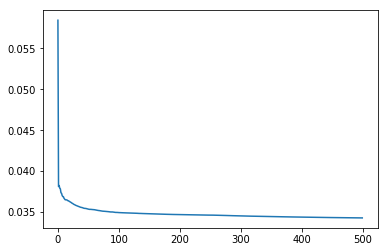

In [199]:
plt.plot(avg_loss_)

In [200]:
path_='omniglot_500_mod7.pth'
torch.save(model.state_dict(), path_)

In [30]:
model.load_state_dict(torch.load('att_faces_500_mod6.pth'))

In [31]:

batch_size=1

# data_transform = transforms.Compose([transforms.Resize(112),
#         transforms.CenterCrop(105),
#         transforms.ToTensor()]) #,transforms.Normalize((0.5,), (0.5,))


dataset_att=att_dataset(main_dir='omniglot/train/',data_transorm=data_transform_test,flag_train=True)
train_loader = torch.utils.data.DataLoader(dataset_att, batch_size=batch_size,shuffle=True)

dataset_att2=att_dataset(main_dir='omniglot/train/',data_transorm=data_transform_test,flag_train=True)
test_loader = torch.utils.data.DataLoader(dataset_att2, batch_size=batch_size,shuffle=True)

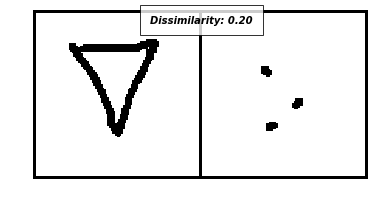

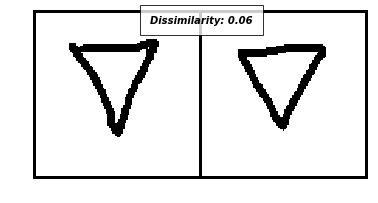

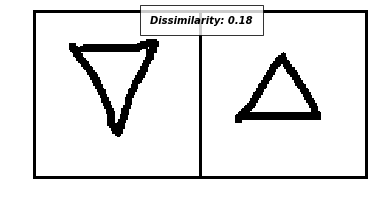

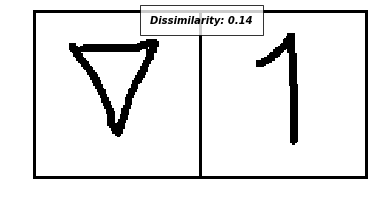

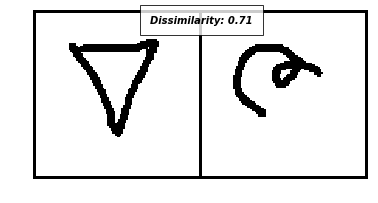

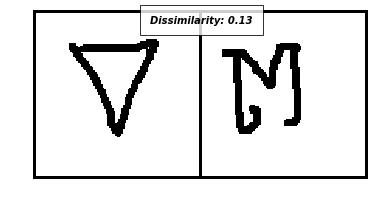

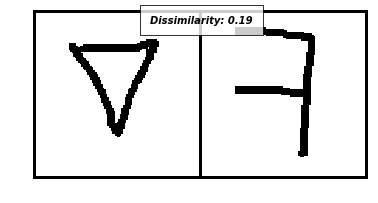

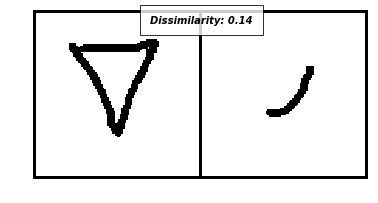

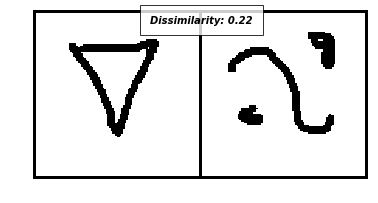

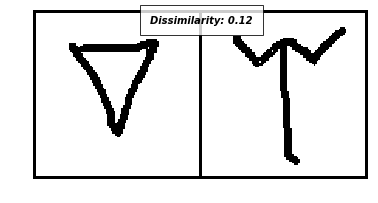

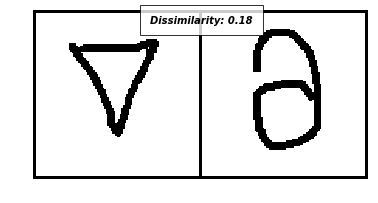

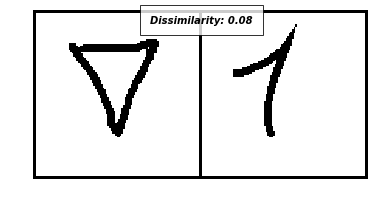

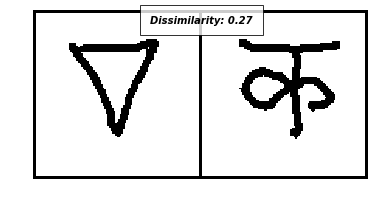

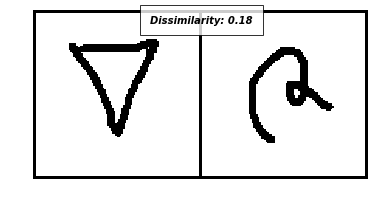

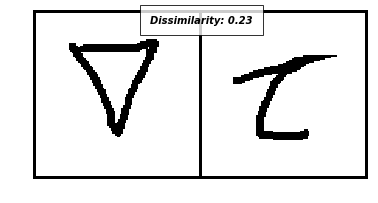

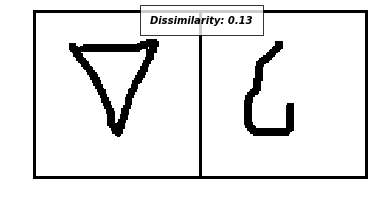

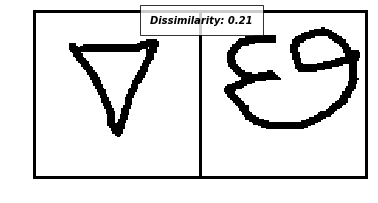

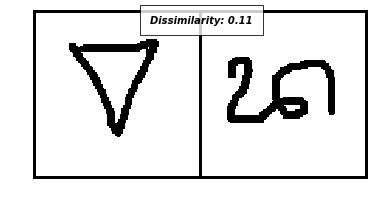

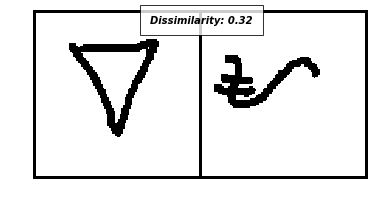

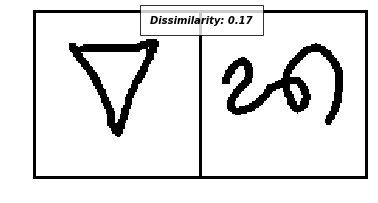

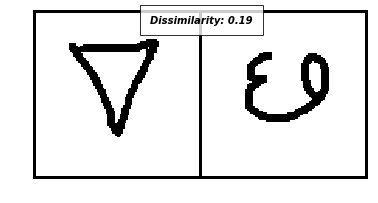

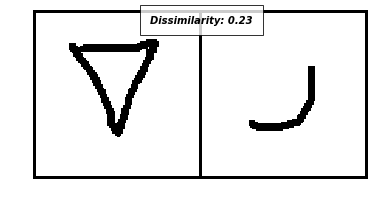

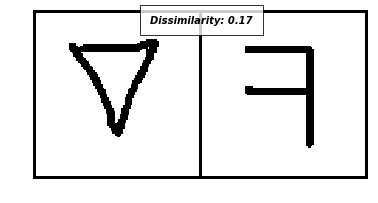

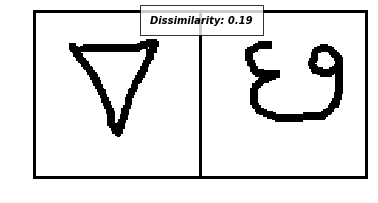

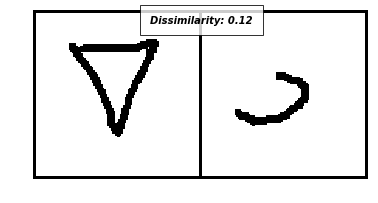

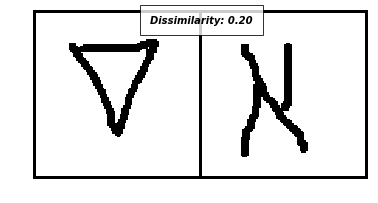

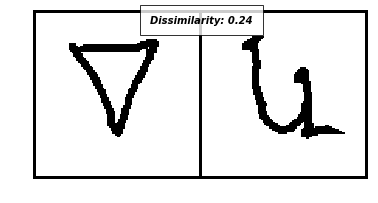

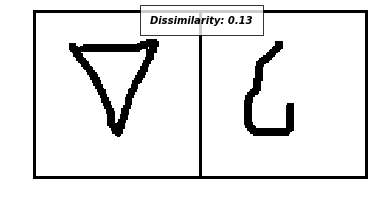

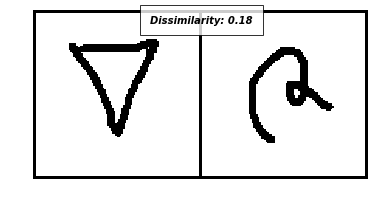

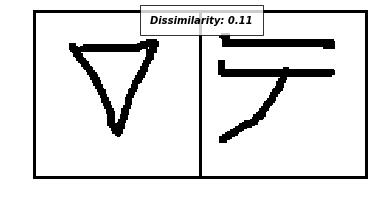

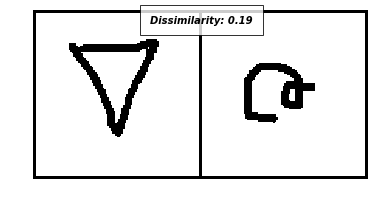

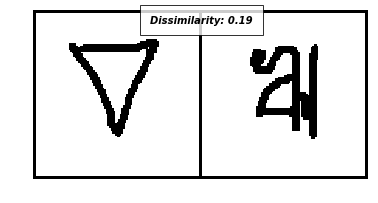

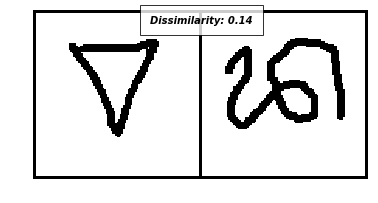

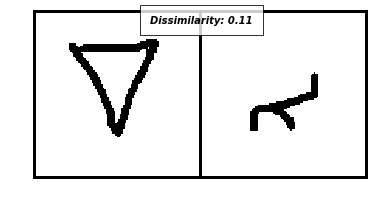

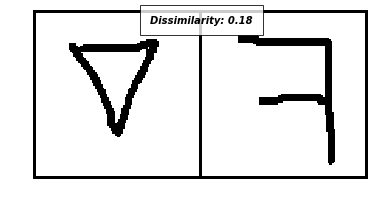

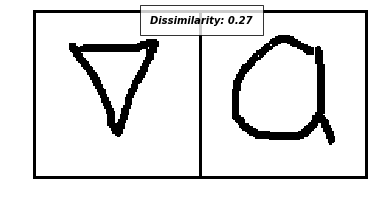

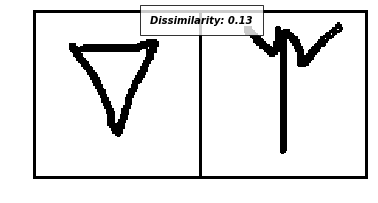

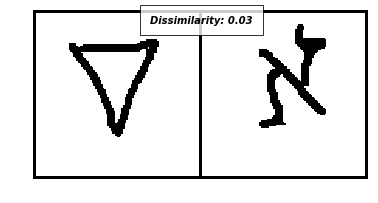

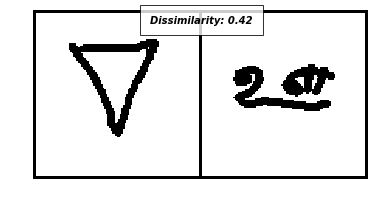

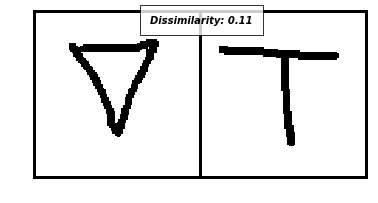

In [40]:
model.to(device)

dataiter = iter(train_loader)
img1,_,_ = next(dataiter)

#for step,(img1,img2,labels) in enumerate(train_loader):
with torch.no_grad():    
    for i in range(40):

        _,img2,labels = next(dataiter)

        model.eval()
        img1=img1.to(device)  #have to turnof device since weight saved not as cuda! after reloading saved model
        img2=img2.to(device)

        concatenated = torch.cat((img1,img2),0)
        #img1=img1.to(device)
        #img2=img2.to(device)
        labels=labels.to(device)

        output1,output2=model(img1,img2)   
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss=criterion(output1,output2,labels)    
        imshow(torchvision.utils.make_grid(concatenated.cpu()),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

In [39]:
count=0
countj=0

for j in range(50):
    countj=countj+1
    print('--------------------------')
    dataiter = iter(train_loader)
    img1,_,_ = next(dataiter)
    distance_init=100.0
    label_save=None

    #for step,(img1,img2,labels) in enumerate(train_loader):
    with torch.no_grad():    
        for i in range(50):

            _,img2,labels = next(dataiter)

            model.eval()
            img1=img1.to(device)
            img2=img2.to(device)

            concatenated = torch.cat((img1,img2),0)
            #img1=img1.to(device)
            #img2=img2.to(device)
            labels=labels.to(device)

            output1,output2=model(img1,img2)   
            euclidean_distance = F.pairwise_distance(output1, output2)
            loss=criterion(output1,output2,labels)
            if(euclidean_distance<distance_init): 
                distance_init=euclidean_distance
                label_save=labels.item()
                
               
            #imshow(torchvision.utils.make_grid(concatenated.cpu()),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))
        if(label_save==1): count=count+1
            
print(count*100./countj)            

--------------------------


KeyboardInterrupt: 